**Summary:**

Transform and apply adversarial patch onto images (single/batch) using tensor manipulation only. Compared to that of D2 where adversarial patches are attached using PIL library.

# Import

In [10]:
import tensorflow as tf
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from six import BytesIO
from six.moves.urllib.request import urlopen
from PIL import Image, ImageDraw, ImageFont

In [11]:
%matplotlib inline

# Load Image

In [12]:
debug = True

In [19]:
def load_image_into_numpy_array(path):
  """
  Argument:
    path - The URL to an online image

  Return: Numpy array of the image from given URL
  """
  image = None

  response = urlopen(path)
  image_data = response.read()
  image_data = BytesIO(image_data)
  image = Image.open(image_data)

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

def load_image_into_numpy_array_os(path):
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape((im_height, im_width, 3))

In [21]:
if debug is False:
  train_image_np = load_image_into_numpy_array('https://i.pinimg.com/736x/99/01/99/9901994565728b73a7ed052a3fda942c.jpg')
else:
  train_image_np = load_image_into_numpy_array_os('/content/report_image.png')
train_image = tf.convert_to_tensor(train_image_np, dtype=tf.float32)

In [22]:
train_image_gt_boxes_np = [[0.08611111, 0.27433628, 0.96111111, 0.68436578]]
train_image_gt_boxes = tf.convert_to_tensor(train_image_gt_boxes_np, dtype=tf.float32)

In [23]:
train_image_gt_classes_np = [[1]]
train_image_gt_classes = tf.convert_to_tensor(train_image_gt_classes_np, dtype=tf.float32)

# Preprocess Image

In [24]:
standard_height = 1024
standard_width = 1024

train_preprocessed_image = tf.image.resize_with_pad(train_image, standard_height, standard_width)

In [25]:
if debug is False:
  train_preprocessed_image_gt_boxes_np = [0.08611111, 0.34375, 0.95611111, 0.6125]
else:
  train_preprocessed_image_gt_boxes_np = [0.34737039, 0.30686799, 0.63500935, 0.44097999]
train_preprocessed_image_gt_boxes = tf.convert_to_tensor(train_preprocessed_image_gt_boxes_np, dtype=tf.float32)

#Init


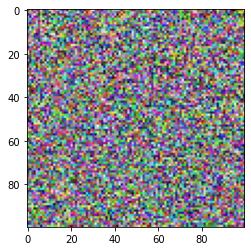

In [26]:
def init(height=100, width=100, random=False, random_seed=14):
  """Return a tf.constant with shape (1, height, width, 3) with value [0, 1]
  """

  if random is True:
    random = tf.random.Generator.from_seed(random_seed)
    adversarial_patch = random.uniform(shape=(1, height, width, 3), minval=0, maxval=1, dtype=tf.float32)
  else:
    adversarial_patch = tf.constant(0.5, shape=[1, height, width, 3], dtype=tf.float32)

  return adversarial_patch

def patch_print(patch):
  """Print adversarial patch using matplotlib"""
  squeezed_patch = tf.squeeze(patch)
  plt.imshow(squeezed_patch.numpy())

adversarial_patch = tf.Variable(initial_value=init(random=True))
patch_print(adversarial_patch)

In [ ]:
debug_adversarial_patch = tf.Variable(tf.constant())

#Transform


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


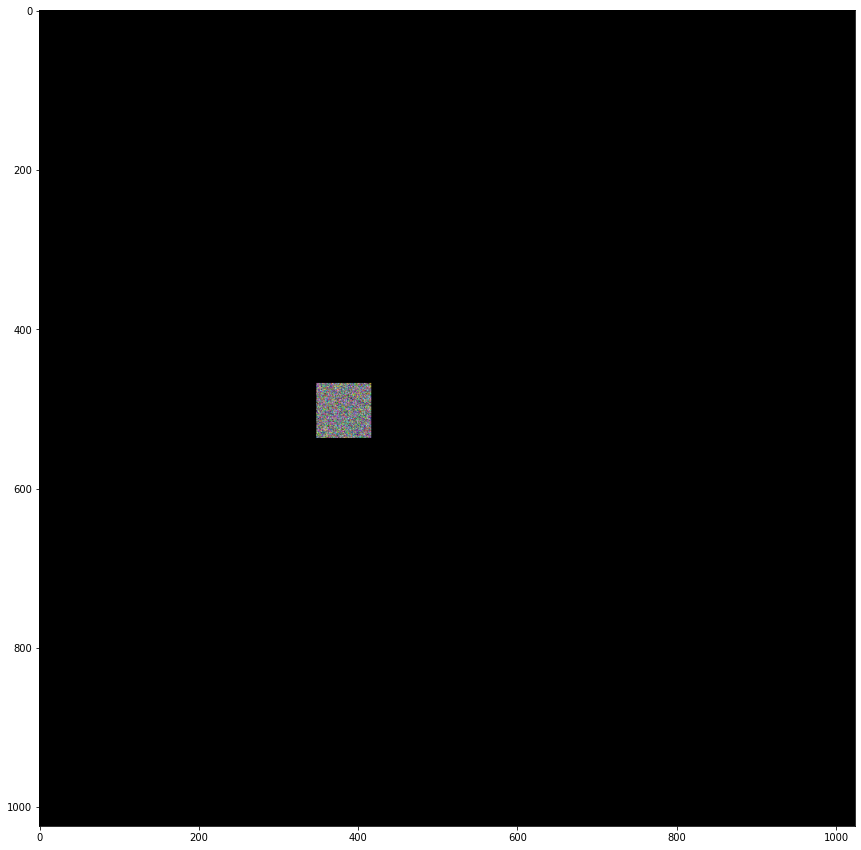

In [30]:
@tf.function(input_signature=(
    tf.TensorSpec(shape=[4], dtype=tf.float32),
    tf.TensorSpec(shape=[1, 100, 100, 3], dtype=tf.float32),
    tf.TensorSpec(shape=[], dtype=tf.float32),
    tf.TensorSpec(shape=[], dtype=tf.bool),
    tf.TensorSpec(shape=[], dtype=tf.bool)
))
def transform(box, patch,
              mask_width=tf.constant(1024, tf.float32),
              random_size=tf.constant(False),
              random_location=tf.constant(False)):
  """
  Generate an adversarial patch mask

  Argument:
    box - A bounding boxes normalised coordinates of shape (4)
    patch - A tf.Variable training adversarial patch of shape (1, 100, 100, 3) with range [0, 1]

  Return:
    An adversarial patch mask of shape (1, 640, 640, 3) with range [0, 255], and where irrelevant spaces are occupied with constant -1
  """
  # Convert patch to range [0, 255], then fudge the patch by 1 such that the black pixel is (1, 1, 1) instead of (0, 0, 0)
  patch = tf.add(tf.math.round(tf.multiply(tf.squeeze(patch), 255.0)), 1.0)

  # Get box information
  denormalised_box = tf.math.round(tf.multiply(box, mask_width))

  ymin, xmin, ymax, xmax = tf.unstack(denormalised_box, axis=0)
  box_height = ymax - ymin
  box_width = xmax - xmin

  # Resize patch to be 0.4 - 0.6 factor smaller than the box
  if random_size is True:
    patch_to_box_factor = tf.cast(tf.squeeze(tf.random.uniform(shape=[1], minval=0.4, maxval=0.6, dtype=tf.float32)), dtype=tf.float32)
  else:
    patch_to_box_factor = tf.constant(0.5, tf.float32)

  patch_width = tf.math.round(tf.multiply(tf.where(box_height > box_width, box_width, box_height), patch_to_box_factor))
  patch = tf.image.resize(patch, size=[patch_width, patch_width])

  # Create an imaginary box for the top-left corner of the patch
  imaginary_box_height = box_height - patch_width
  imaginary_box_width = box_width - patch_width

  if random_location is True:
    # Randomly pick a location on a person
    yloc = tf.squeeze(tf.random.uniform(shape=[1], minval=0.4, maxval=0.6, dtype=tf.float32))
    xloc = tf.squeeze(tf.random.uniform(shape=[1], minval=0.4, maxval=0.6, dtype=tf.float32))
  else:
    yloc = tf.constant(0.5, tf.float32)
    xloc = tf.constant(0.5, tf.float32)

  ystart = tf.cast(tf.clip_by_value(ymin + tf.math.round(imaginary_box_height * yloc), 0, mask_width-patch_width), tf.int32)
  xstart = tf.cast(tf.clip_by_value(xmin + tf.math.round(imaginary_box_width * xloc), 0, mask_width-patch_width), tf.int32)
  mask_width = tf.cast(mask_width, tf.int32)

  # Expand the patch image such that patch is on the bounding box of a person
  transformed_patch = tf.image.pad_to_bounding_box(patch, ystart, xstart, mask_width, mask_width)

  # Padded pixel = [0.0]
  # Fudge the actual black pixel back to (0, 0, 0) whereas the padded area are now (-1, -1, -1)
  transformed_patch = tf.subtract(transformed_patch, 1.0)

  return tf.expand_dims(transformed_patch, axis=0)

#DEBUG_FUNCTION:
# plt.imshow(train_preprocessed_image.numpy().astype(int))
adv_patch_mask = transform(train_preprocessed_image_gt_boxes, adversarial_patch)
plt.figure(figsize=(15,15))
plt.imshow(adv_patch_mask.numpy().astype(int)[0])

# debug_adv_patch_mask = tf.image.resize(tf.squeeze(adv_patch_mask), [10, 10])
# print(debug_adv_patch_mask.numpy()[:,:,0])

#Apply

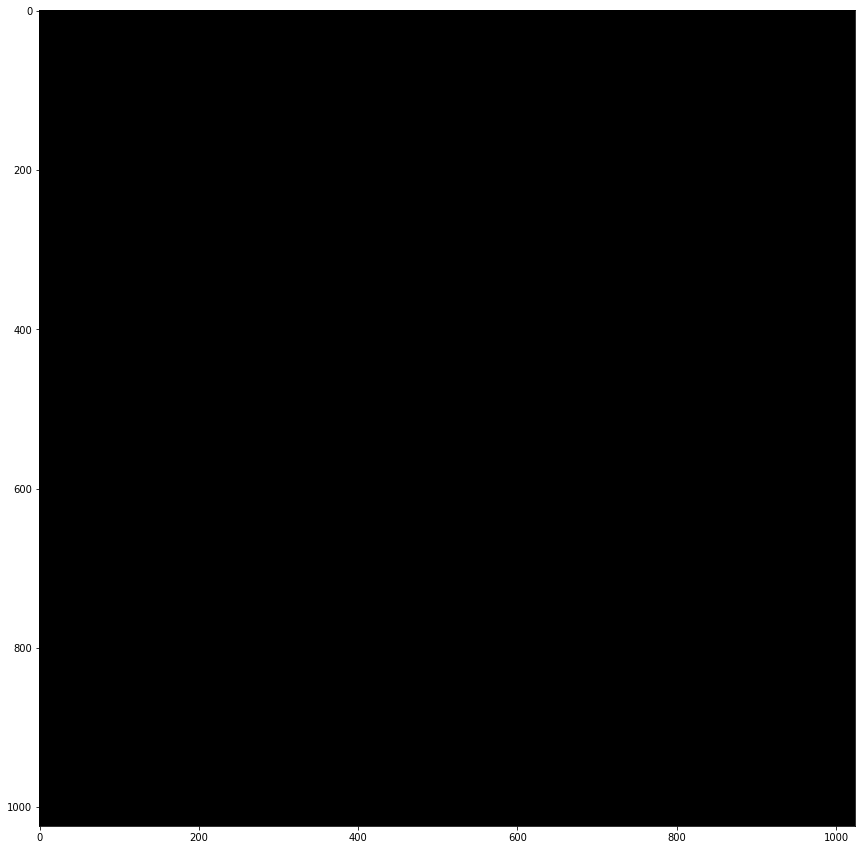

In [34]:
empty = tf.constant(0, shape=[1024, 1024, 3], dtype=tf.int32)
plt.figure(figsize=(15,15))
plt.imshow(empty.numpy().astype(int))

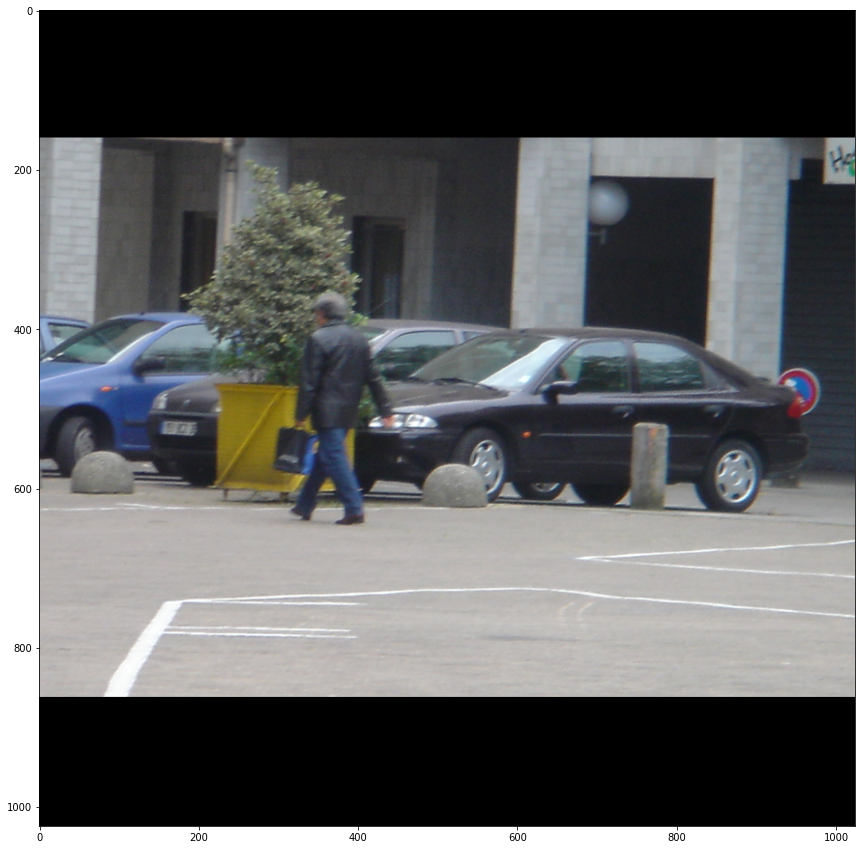

In [32]:
plt.figure(figsize=(15,15))
plt.imshow(train_preprocessed_image.numpy().astype(int))

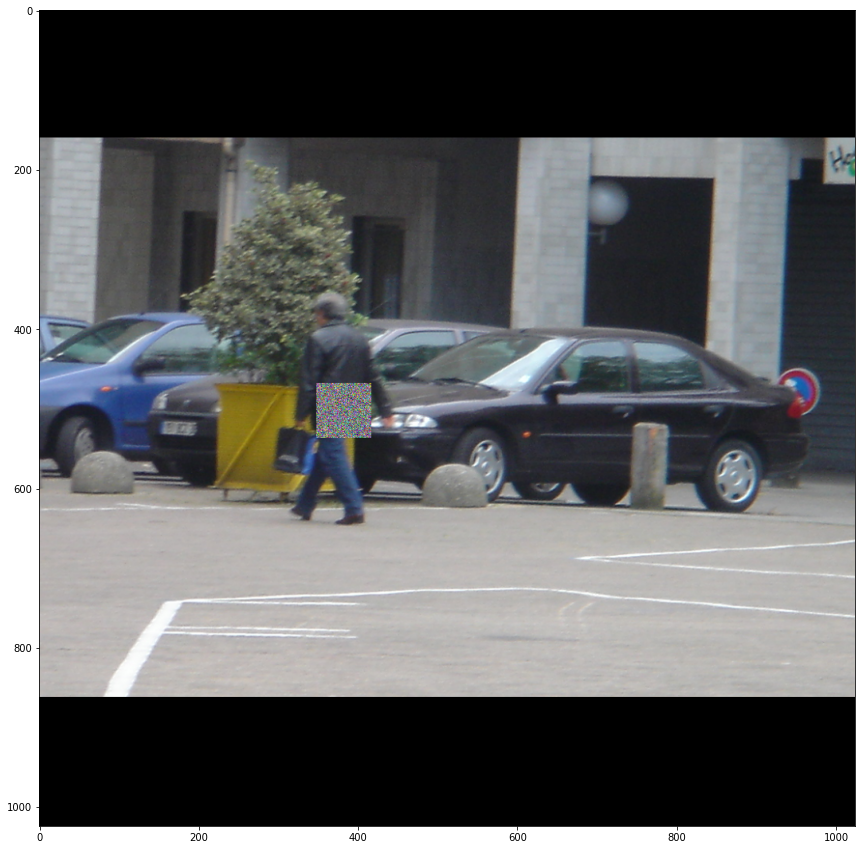

In [33]:
@tf.function(input_signature=(
    tf.TensorSpec(shape=[None, 1024, 1024, 3], dtype=tf.float32),
    tf.TensorSpec(shape=[None, 1024, 1024, 3], dtype=tf.float32)
))
def apply(image, patch):
  """
  Apply patch mask onto image

  Argument:
    image - A tf.float32 image with shape (batch_size, 640, 640, 3)
    patch - An tf.float32 adversarial patch mask of shape (batch_size, 640, 640, 3)

  Return:
    An the combination of image and patch
  """
  applied_patch = tf.where(patch == -1.0, image, patch)

  return applied_patch

#DEBUG
adv_patch_mask = transform(train_preprocessed_image_gt_boxes, adversarial_patch)
result = apply(tf.expand_dims(train_preprocessed_image, axis=0), adv_patch_mask)
plt.figure(figsize=(15,15))
plt.imshow(result.numpy().astype(int)[0])

In [ ]:
train_preprocessed_image = tf.expand_dims(train_preprocessed_image, axis=0)
train_preprocessed_images = tf.concat([train_preprocessed_image, train_preprocessed_image], axis=0)

In [ ]:
print(tf.shape(train_preprocessed_images))

tf.Tensor([   2 1024 1024    3], shape=(4,), dtype=int32)


In [ ]:
adv_patch_masks = tf.concat([adv_patch_mask, adv_patch_mask], axis=0)

In [ ]:
print(tf.shape(adv_patch_masks))

tf.Tensor([   2 1024 1024    3], shape=(4,), dtype=int32)


In [ ]:
results = apply(tf.subtract(tf.divide(train_preprocessed_images, 127.5), 1.0), adv_patch_masks)

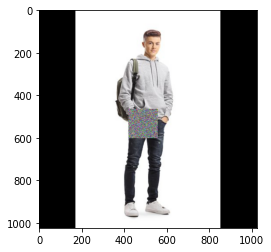

In [ ]:
plt.imshow(tf.divide(tf.add(results, 1.0), 2.0).numpy().astype(float)[0])

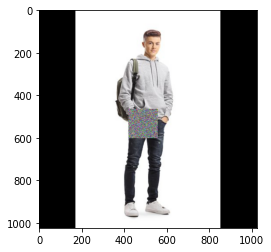

In [ ]:
plt.imshow(tf.divide(tf.add(results, 1.0), 2.0).numpy().astype(float)[1])

#Simple

In [ ]:
@tf.function(input_signature=(
    tf.TensorSpec(shape=[1, 4], dtype=tf.float32),
    tf.TensorSpec(shape=[1, 100, 100, 3], dtype=tf.float32),
    tf.TensorSpec(shape=[], dtype=tf.float32)
))
def transform_simple(box, patch, mask_width=tf.constant(640, tf.float32)):
  """
  Generate an adversarial patch mask

  Argument:
    box - A bounding boxes normalised coordinates with shape (1, 4)
    patch - A tf.Variable training adversarial patch of shape (1, None, None, 3)

  Return:
    An adversarial patch mask of shape (1, 640, 640, 3) where irrelevant spaces are
    occupied with constant -1
  """
  # Fudge patch such that there're no black [0, 0, 0] pixel
  patch = tf.add(patch, 1)

  #TODO: Environment transformation of the adversarial patch

  # Get box information
  denormalised_box = tf.math.round(tf.multiply(tf.squeeze(box), mask_width))

  ymin, xmin, ymax, xmax = tf.unstack(denormalised_box, axis=0)
  box_height = ymax - ymin
  box_width = xmax - xmin

  patch_width = tf.math.round(tf.multiply(tf.where(box_height > box_width, box_width, box_height), 0.5))
  patch = tf.image.resize(tf.squeeze(patch), size=[patch_width, patch_width])

  # Create an imaginary box for the top-left corner of the patch
  imaginary_box_height = box_height - patch_width
  imaginary_box_width = box_width - patch_width

  ystart = tf.cast(tf.clip_by_value(ymin + tf.math.round(imaginary_box_height * 0.5), 0, mask_width-patch_width), tf.int32)
  xstart = tf.cast(tf.clip_by_value(xmin + tf.math.round(imaginary_box_width * 0.5), 0, mask_width-patch_width), tf.int32)
  mask_width = tf.cast(mask_width, tf.int32)

  # Expand the patch image such that patch is on the bounding box of a person
  transformed_patch = tf.image.pad_to_bounding_box(patch, ystart, xstart, mask_width, mask_width)

  # Padded pixel = (0, 0, 0), black pixel = (1, 1, 1)
  # Unfudge the patch such that padded pixel = (-1, -1, -1), black pixel = (0, 0, 0)
  # This will cause clipping warning when display using matplotlib
  transformed_patch = tf.subtract(transformed_patch, 1)

  return tf.expand_dims(transformed_patch, axis=0)

#DEBUG_FUNCTION:
# print_image(train_preprocessed_image)
# adv_patch_mask = transform_simple(train_preprocessed_image_gt_boxes, adv_patch, tf.constant(1024, tf.float32))
# print_image(adv_patch_mask[0]) 

In [ ]:
import timeit

adv_patch_mask = transform_simple(train_preprocessed_image_gt_boxes, adv_patch, tf.constant(1024, tf.float32))
adv_patch_mask = transform(train_preprocessed_image_gt_boxes, adv_patch, tf.constant(1024, tf.float32))

print("Simple:", timeit.timeit(lambda: transform_simple(train_preprocessed_image_gt_boxes, adv_patch, tf.constant(1024, tf.float32)), number=100))
print("Complicated:", timeit.timeit(lambda: transform(train_preprocessed_image_gt_boxes, adv_patch, tf.constant(1024, tf.float32)), number=100))

Simple: 1.323477602998537
Complicated: 1.3328391509985522
